In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import math
import afm_functions as afm


def step_graph(file):
    keys = list(file.keys())
    counter = 1

    for i in range(0, len(keys), 2):
        # Create a new figure for each profile
        plt.figure()

        x = [val * 1e9 for val in file[keys[i]]]       # Convert x to nm
        y = [val * 1e9 for val in file[keys[i + 1]]]   # Convert y to nm

        line, = plt.plot(x, y, label=f"Profile {counter}")
        line_color = line.get_color()

        scatter_points = []
        for k in range(len(y)):
            if y[k - 1] != y[k - 2] or k == 1:
                plt.scatter(x[k - 1], y[k - 1], color=line_color, s=7)
                scatter_points.append((x[k - 1], y[k - 1]))

        # Filter out NaN values
        scatter_points = [pt for pt in scatter_points if not (math.isnan(pt[0]) or math.isnan(pt[1]))]

        # Annotate each scatter point
        for point, j in enumerate(scatter_points):
            plt.annotate(point, j, textcoords="offset points", xytext=(0, 5), ha='center',
                         fontsize=9, color=line_color,
                         path_effects=[pe.withStroke(linewidth=2, foreground="white")])

        plt.legend()
        plt.xlabel("Position (nm)")
        plt.ylabel("Height (nm)")
        plt.title(f"Step Profile {counter}")

        plt.show()
        counter += 1

#function for splitting apart heights
def average_step(data, threshold):
    averaged_data = data.copy()
    averaged_data_steps = {}
    keys = list(averaged_data.keys())
    for i in range(1, len(keys), 2):
        values = averaged_data[keys[i]]
        current_step = []
        steps = []
        for k in range(0,len(values)):
            if abs(values[k] - values[k - 1]) <= threshold:
                current_step.append(values[k])
            else:
                if current_step:
                    steps.append(current_step)
                current_step = [values[k]]
        if current_step:
            steps.append(current_step)
        averaged_values = []
        for step in steps:
            avg = float(np.mean(step))
            averaged_values.extend([avg] * len(step))
        averaged_data_steps[keys[i]] = [[float(np.mean(step))] * len(step) for step in steps]
        averaged_data[keys[i]] = averaged_values
    return averaged_data, averaged_data_steps, (len(keys) // 2)
    
#find heights
def heights(data, profile, index1, index2):
    height = data[f'height{profile}'][index2][0] - data[f'height{profile}'][index1][0]
    return height


def avg_thickness(data):
    steps, steps_lists, num_profiles = average_step(data, 2e-9)
    step_graph(steps)
    thickness = []
    bounds = []
    step_locations = []
    for i in range(num_profiles):
        index1 = input(f"Index 1 for Profile {i+1}: ").strip()
        index2 = input(f"Index 2 for Profile {i+1}: ").strip()
        pos = steps[f'height{i+1}'].index(steps_lists[f'height{i+1}'][int(index2)][0])
        step_locations.append(pos)
        bounds.append((steps_lists[f'height{i+1}'][int(index1)][0], steps_lists[f'height{i+1}'][int(index2)][0]))
        thickness.append(heights(steps_lists, i+1, int(index1), int(index2)))
    print("Thicknesses:", thickness)
    avg_thickness = np.mean(thickness)
    print("Average Thickness:", avg_thickness)
    return avg_thickness, bounds, step_locations

In [5]:
ptte = afm.import_data(r"C:\Users\poeda\OneDrive\Documents\Luo Group\AFM Images\TRT PtTe\Kyle Data\PtTe1.017 profiles.csv")
steps, steps_lists, num_profiles = average_step(ptte, 2e-9)


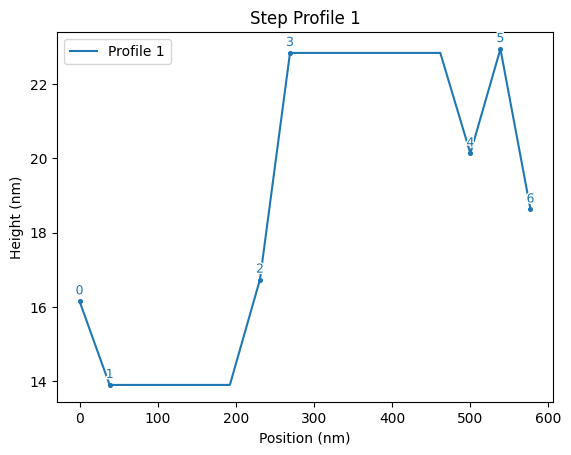

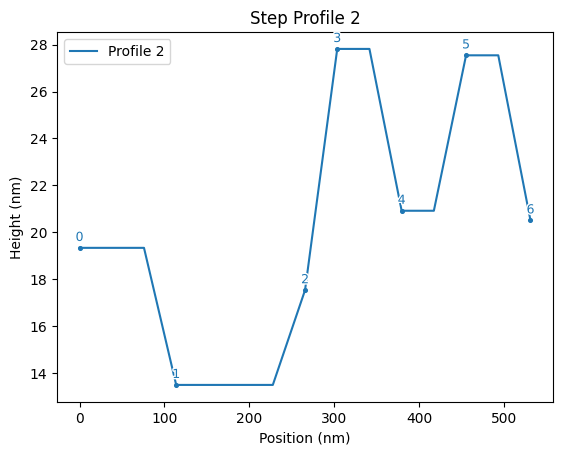

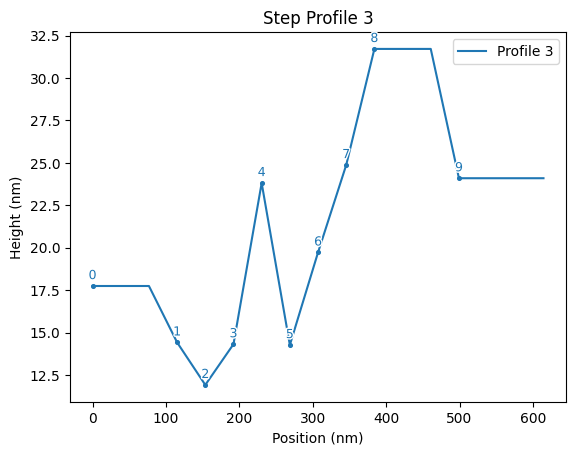

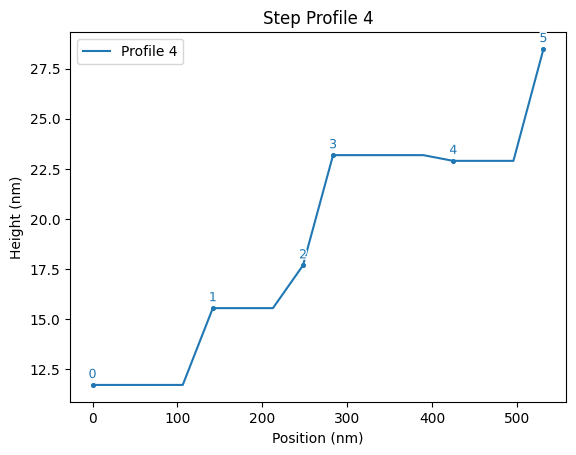

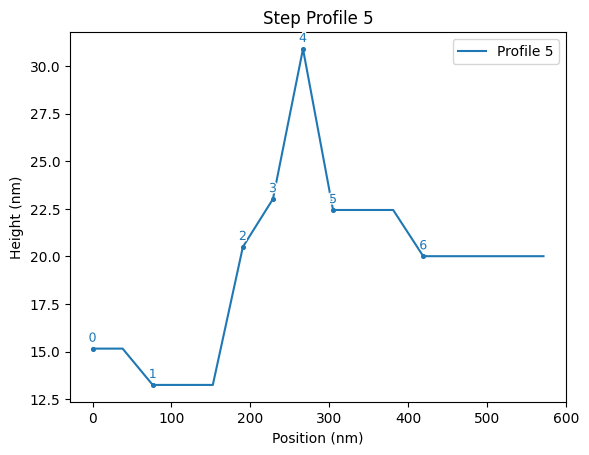

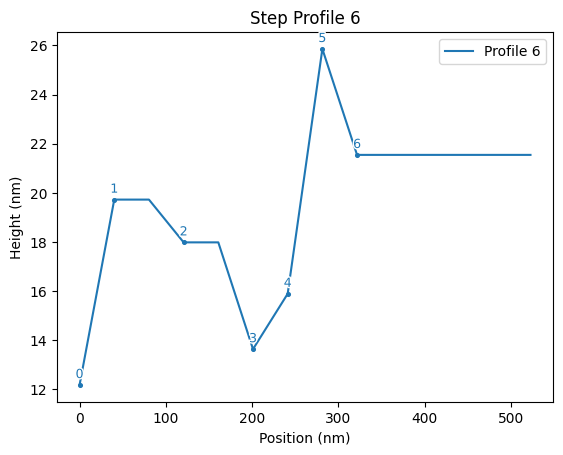

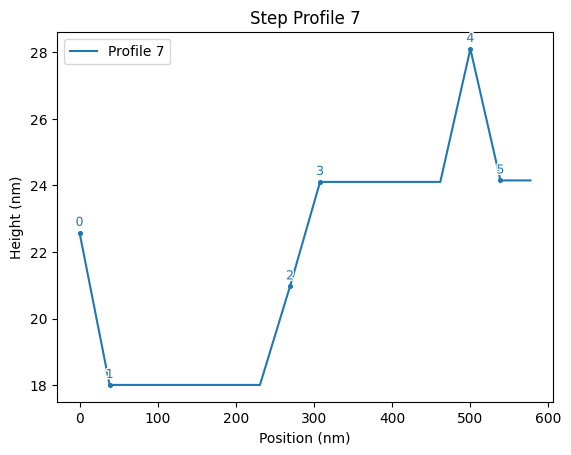

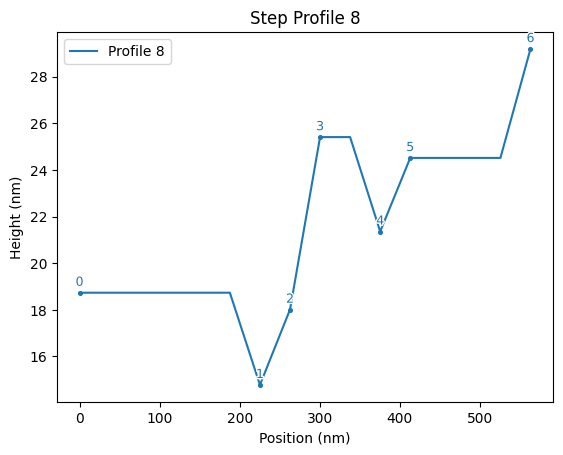

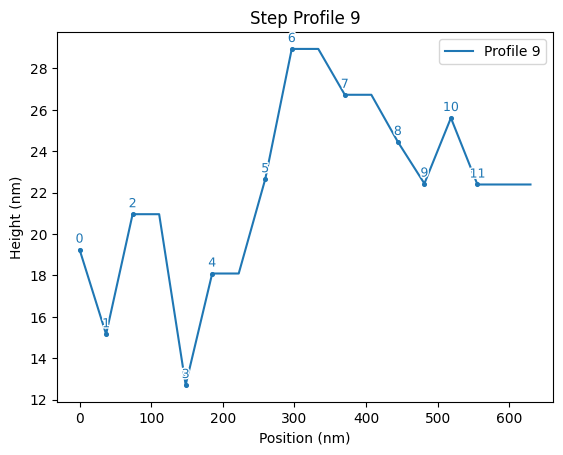

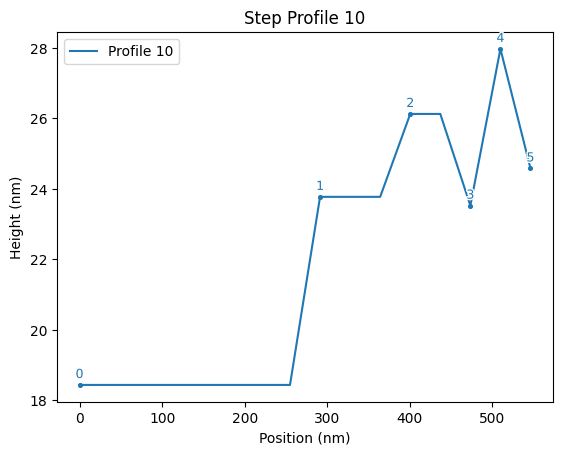

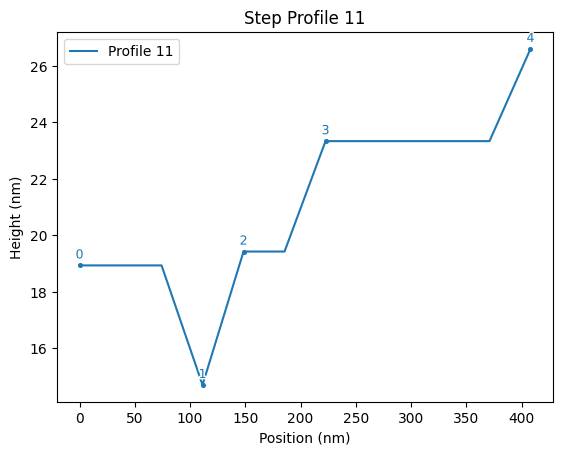

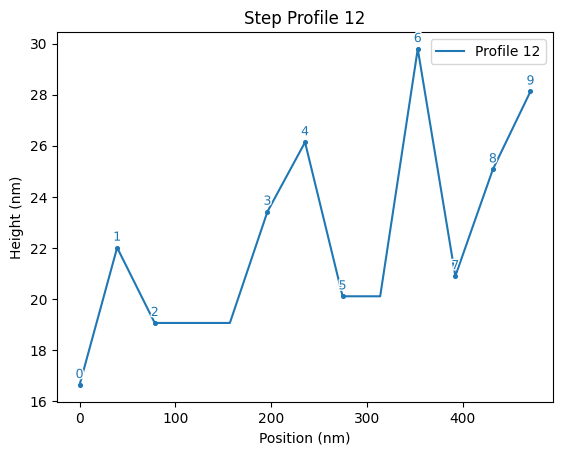

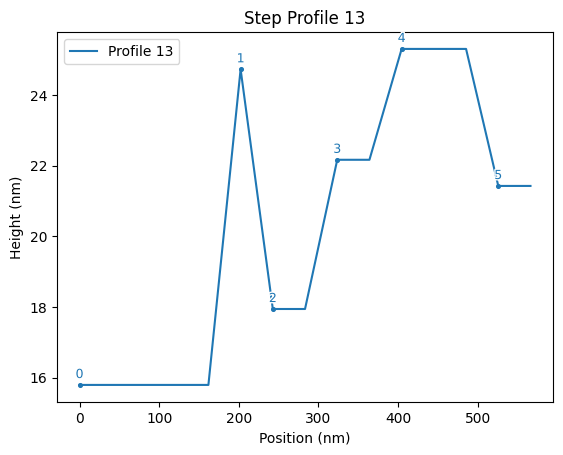

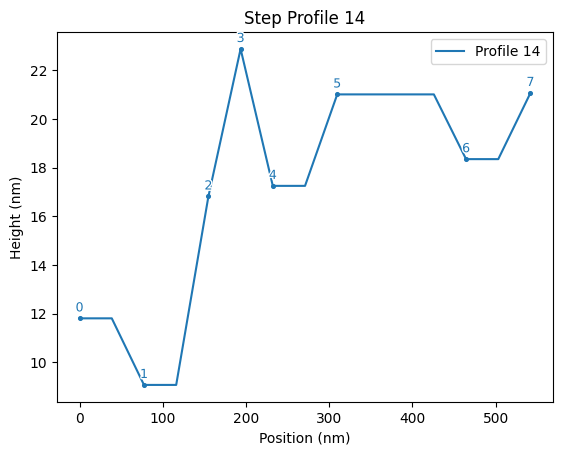

Thicknesses: [8.94622256666667e-09, 7.426858999999997e-09, 6.349480333333333e-09, 1.14617555e-08, 6.758797400000001e-09, 9.363465333333333e-09, 6.0933883666666645e-09, 5.783548833333333e-09, 4.300359333333333e-09, 5.3373378333333325e-09, 4.397849399999999e-09, 9.070225999999997e-09, 9.500876266666668e-09, 9.199200999999998e-09]
Average Thickness: 7.4278119404761915e-09


In [6]:
thickness, bounds, step_locations = avg_thickness(ptte)

In [ ]:
lower_bound = [bound[0] for bound in bounds]
upper_bound = [bound[1] for bound in bounds]
avg_lower = np.mean(lower_bound)
avg_upper = np.mean(upper_bound)
avg_len = [len(steps[key]) for key in list(steps.keys())[::2]][0]
avg_step_locations = int(np.mean(step_locations))
print(avg_step_locations)
new_step = [avg_lower] * int(avg_step_locations) + [avg_upper] * int(avg_len - avg_step_locations)
new_dict = {'position_avg': steps['position1'], 'height_avg': new_step} | ptte
height = new_dict['height_avg'][-1] - new_dict['height_avg'][0]


9


In [6]:


def avg_step_graph(file, filename=" ", height=None):
    keys = list(file.keys())
    counter = 1
    raw_plots = []
    
    # Plot all profiles
    for i in range(0, len(keys), 2):
        x = [val * 1e9 for val in file[keys[i]]]
        y = [val * 1e9 for val in file[keys[i + 1]]]
        
        if i == 0:
            # Averaged data: full color, normal opacity
            avg_line, = plt.plot(x, y, label="Averaged Step Height", alpha=1)
            avg_x = x
            avg_y = y
        else:
            # Raw data: colored and semi-transparent
            raw_line, = plt.plot(x, y, label=f"Raw Step Heights {counter}", alpha=0.3)
            raw_plots.append(raw_line)
            counter += 1
    
    # Add a single legend entry for all raw profiles to keep legend clean
    if raw_plots:
        plt.legend(handles=[avg_line, raw_plots[0]], labels=["Averaged Profile", "Raw Profiles"], loc='best')
    else:
        plt.legend(loc='best')
    
    # If height is given, draw the height marker and label
    if height is not None and avg_x is not None and avg_y is not None:
        lower_height = min(avg_y)
        upper_height = max(avg_y)
        # Choose x position for the vertical line (e.g. middle of x range)
        x_pos = avg_x[len(avg_x)//2]
        
        # Draw vertical line showing height change on averaged profile
        plt.vlines(x=x_pos, ymin=lower_height, ymax=upper_height, colors='red', linestyles='--', linewidth=2)
        
        # Display height value next to the vertical line
        mid_y = (lower_height + upper_height) / 2
        plt.text(x_pos, mid_y, f"{float(height*1e9):.2f} nm", color='red', fontsize=10,
                 verticalalignment='center', horizontalalignment='left',
                 bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    
    plt.title(f"{filename} AFM Profiles")
    plt.xlabel("Position (nm)")
    plt.ylabel("Height (nm)")
    plt.show()


#avg_step_graph(new_dict, "TRT PtTe2 AFM Data", height)


In [3]:
def find_average_step(file, threshold=1e-9, plot=False):
    data = afm.import_data(file)
    steps, steps_lists, num_profiles = average_step(data, threshold)
    thickness, bounds, step_locations = avg_thickness(data)
    lower_bound = [bound[0] for bound in bounds]
    upper_bound = [bound[1] for bound in bounds]
    avg_lower = np.mean(lower_bound)
    avg_upper = np.mean(upper_bound)
    avg_len = [len(steps[key]) for key in list(steps.keys())[::2]][0]
    avg_step_locations = int(np.mean(step_locations))
    new_step = [avg_lower] * int(avg_step_locations) + [avg_upper] * int(avg_len - avg_step_locations)
    new_dict = {'position_avg': steps['position1'], 'height_avg': new_step} | data
    height = new_dict['height_avg'][-1] - new_dict['height_avg'][0]
    if plot:
        avg_step_graph(new_dict, "Averaged AFM Data", height)
    return new_dict, height


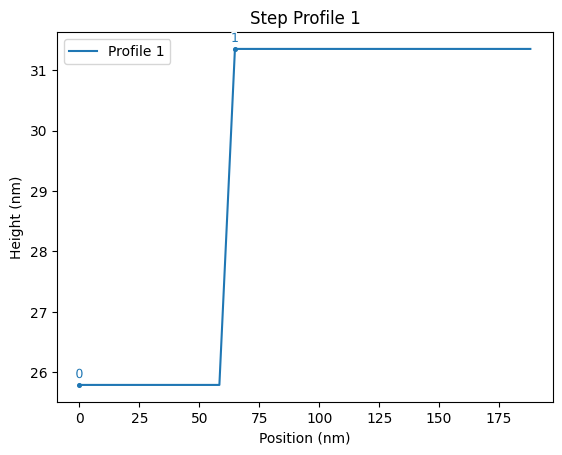

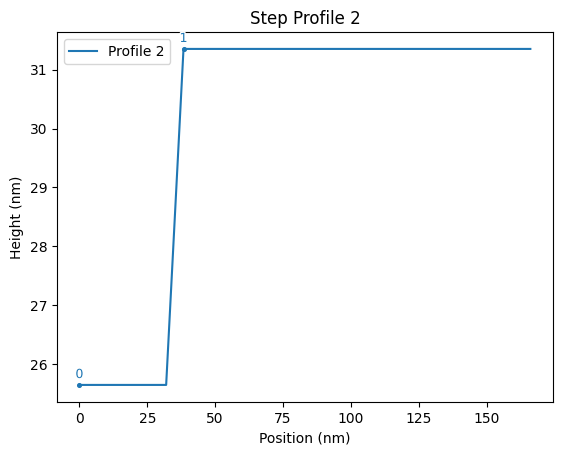

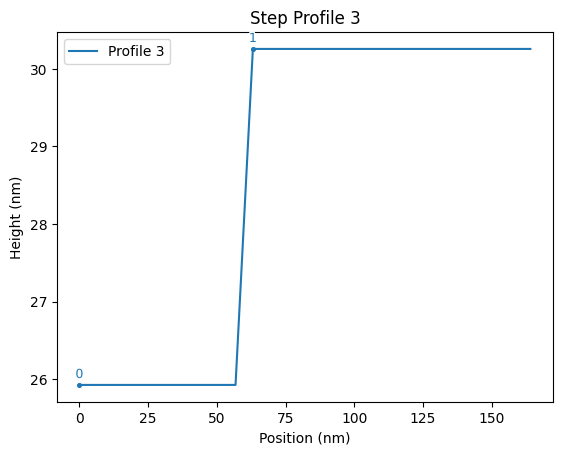

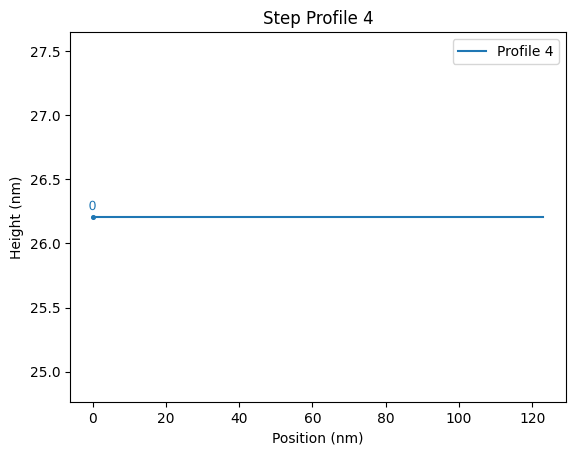

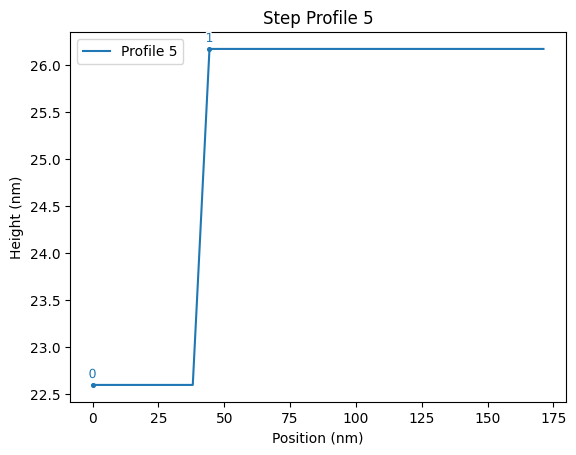

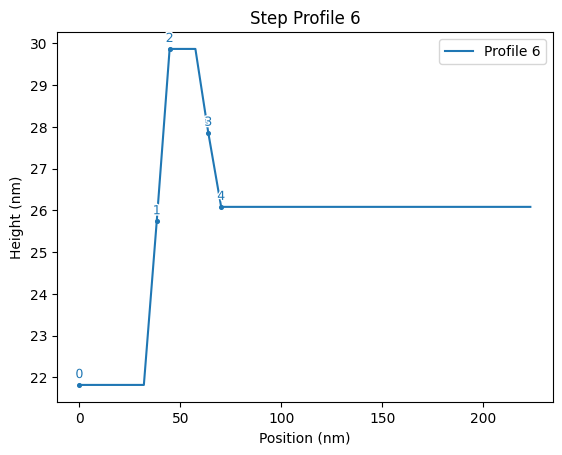

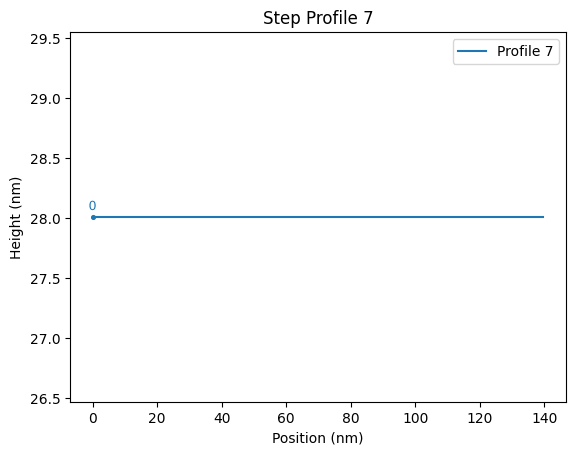

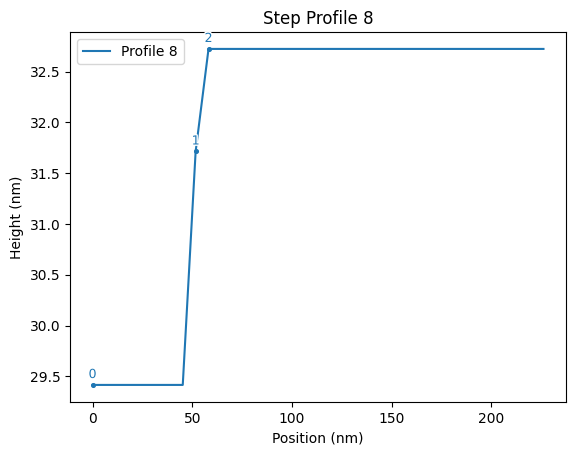

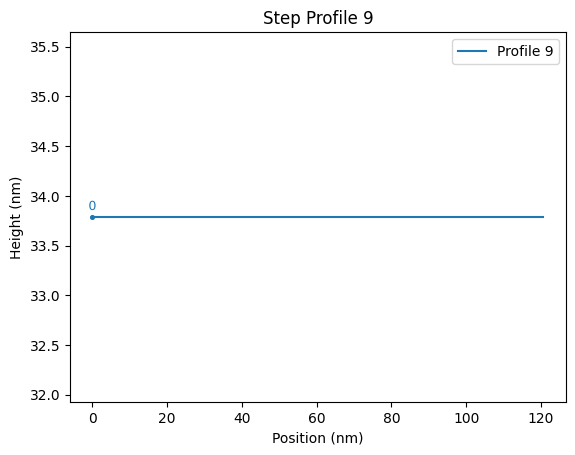

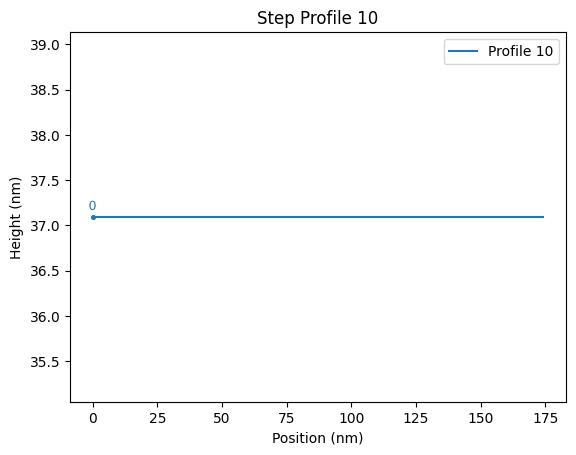

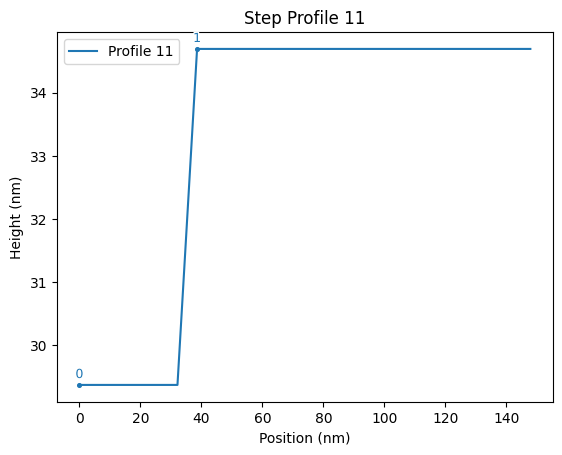

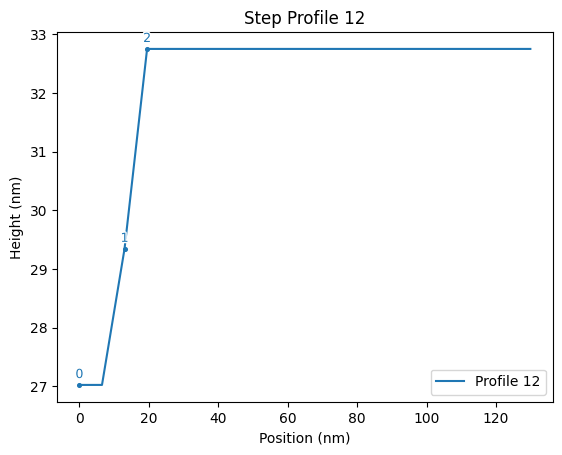

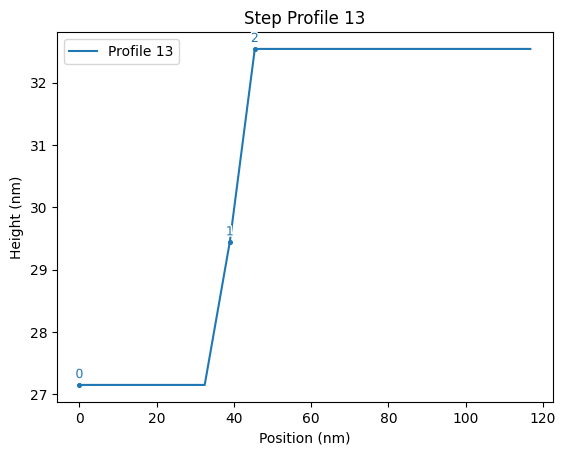

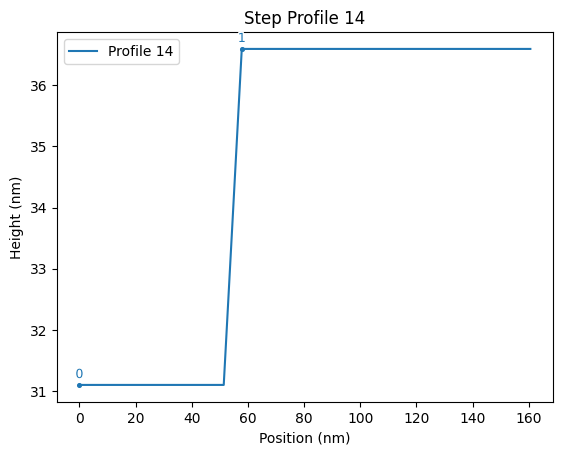

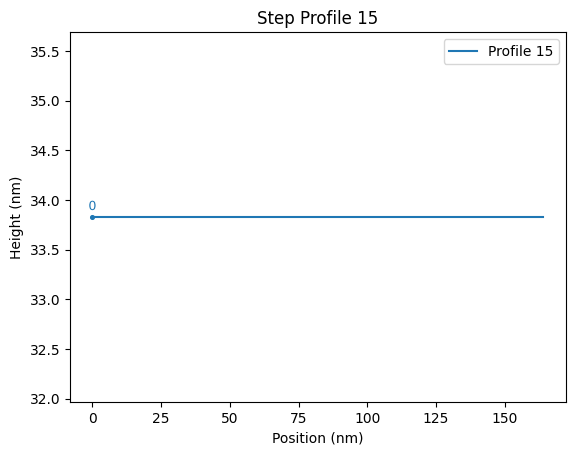

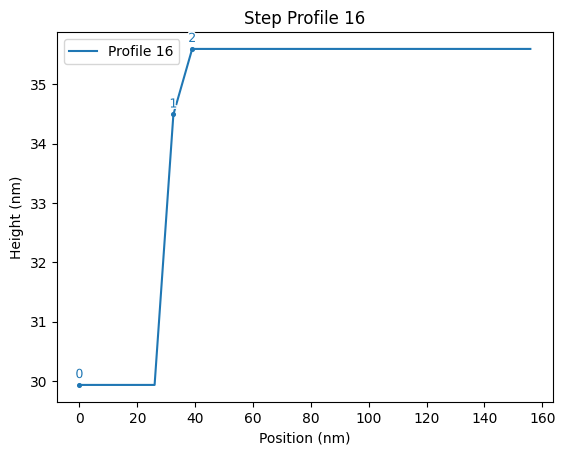

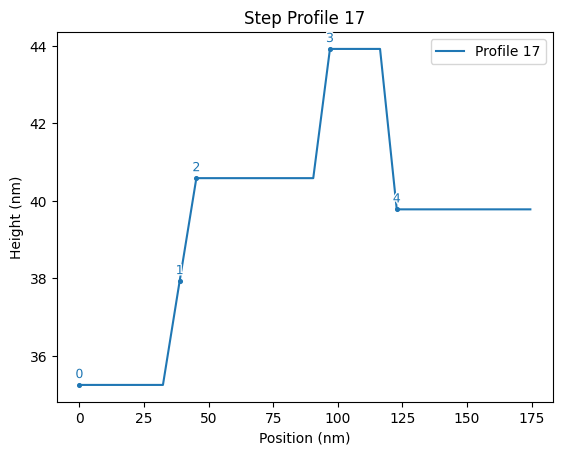

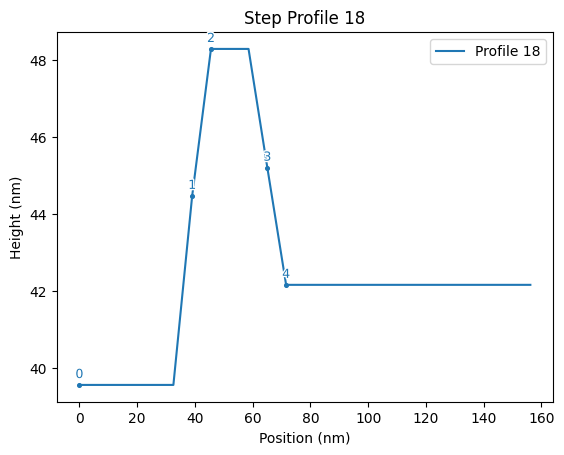

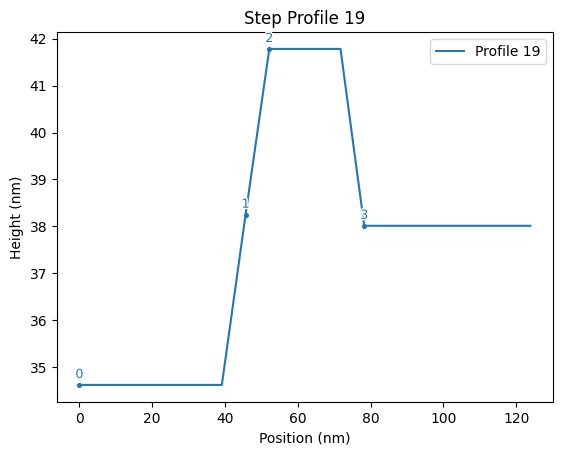

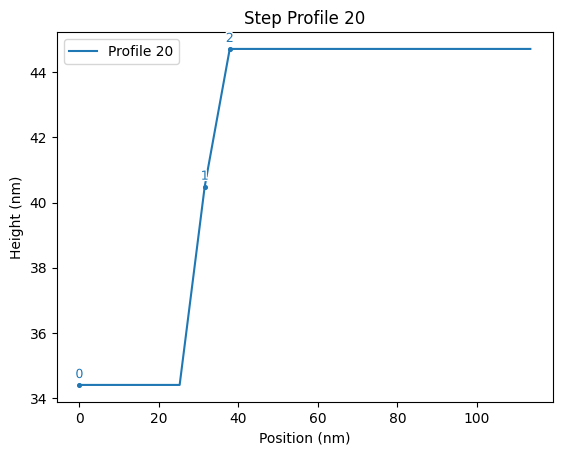

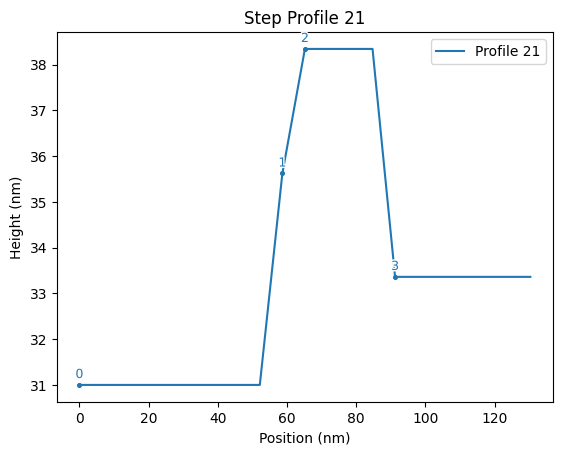

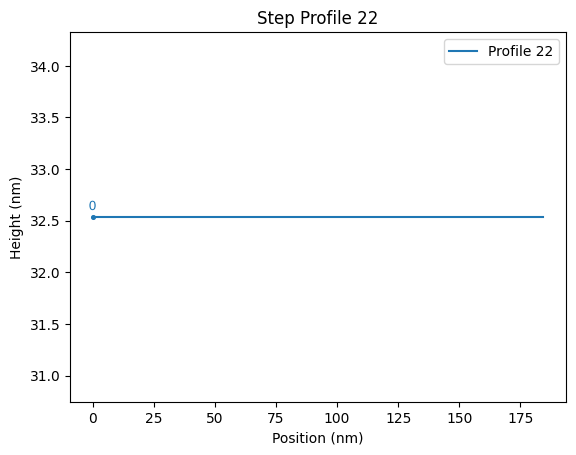

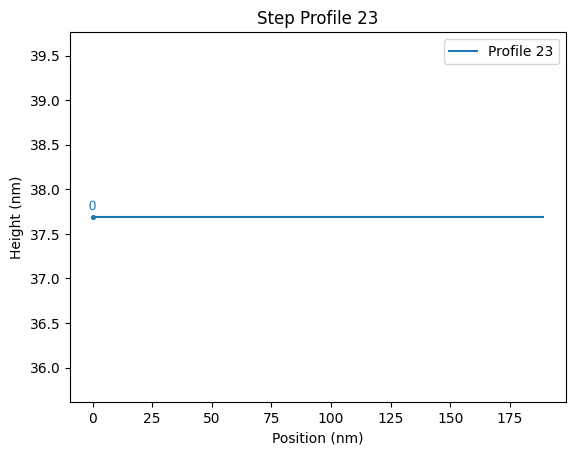

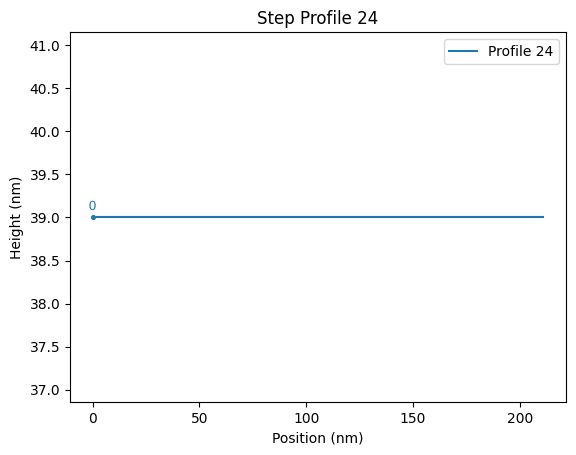

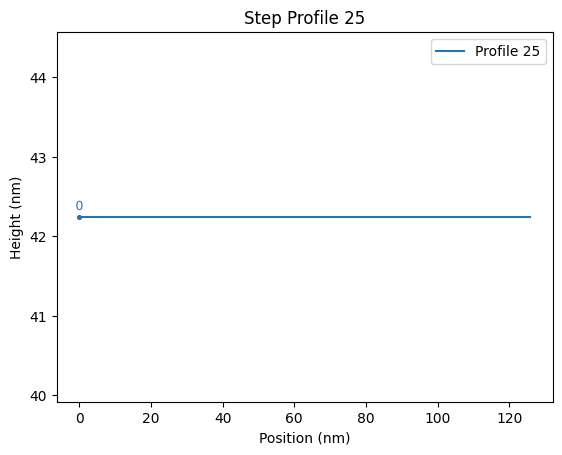

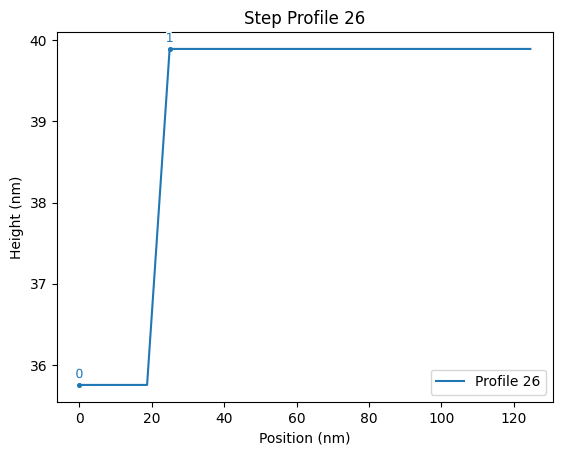

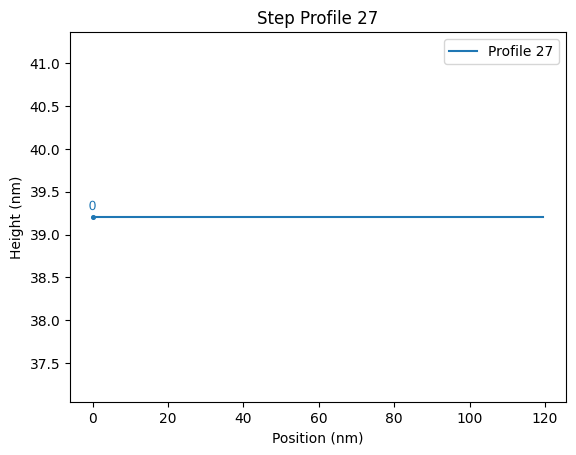

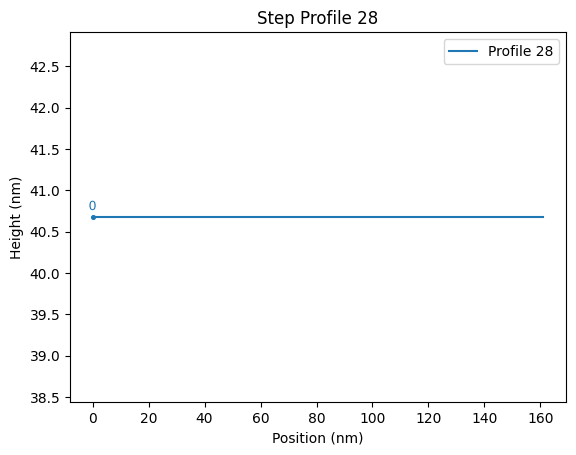

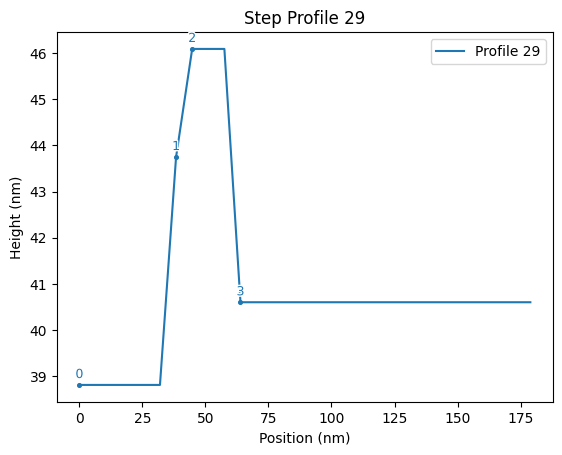

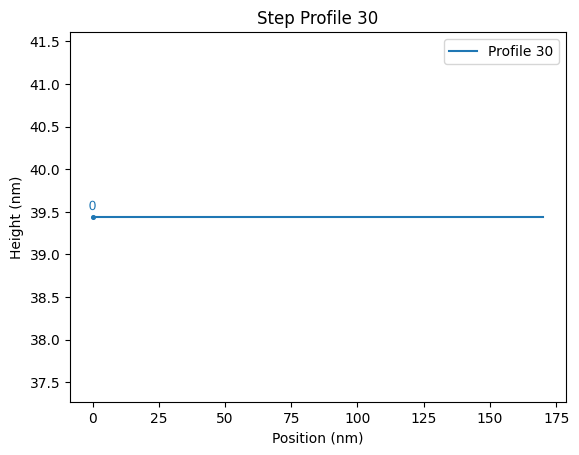

In [ ]:
find_average_step(r"C:\Users\poeda\OneDrive\Documents\Luo Group\AFM Images\CrsBr MTJ Project\CrSBr MTJ #3 Post.004 average steps.csv", threshold = 0,plot=True)